set up and define models
Notations:
* dataset size: $P$
* input feature size: $N$
* parallel synapses per axon: $M$
* hidden layer size (if it's 2-layered neural network): $H$
* output dimension: $O$
* input $x$ has dimension: $[P, N]$

__One layer neural network__ (1-NN):\
Weight matrix $w$ has size $[N, O]$\
Output for each class is $Softmax(x.w)$

__Two layer neural network__ (2-NN):\
Layer 1 weight $w_1$ has size $[H, N]$\
Layer 2 weight $w_2$ has size $[O, H]$\
Hidden layer has output $h = Relu(x.w_1)$\
Output for each class is $Softmax(h.w_2)$

__Parallel synapse neuron__ (1-pNeuron):\
Use $f_M$ to denote element-wise transformation of input, which has $3*M$ learnable parameters for each input dimension\
Input $x$ undergoes parallel synapse computation $f_M(x)$\
Output for each class is $Softmax(f_M(x).w)$

__Two layer neural network with parallel synapse__ (2-NN w pNeuron):\
Again, use $f_M$ to denote element-wise transformation of input,\
Input $x$ undergoes parallel synapse computation $f_M(x)$\
Layer 1 weight $w_1$ has size $[H, N]$, \
Layer 2 weight $w_2$ has size $[O, H]$
Hidden layer has output $h = Relu(f_M(x).w_1)$, \
Output for each class is $Softmax(h.w_2)$


| Model name | #Parameters | #Nonlinear Functions |
|---------|---------|---------|
| 1-NN| $N * O$ |  |
| 2-NN| $H*N + H*O$ | |
| 1-pNeuron|  $3M * N + N * O$  |  |
| 2-NN w pNeuron| $3M * N + H * N +  H * O$ |  |

In [5]:
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F 
from torch.nn import Module, init
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# Check for GPU availability
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# define one-layered neural network
class oneLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(twoLayerNN, self).__init__()
        self.fc = nn.Linear(input_dim,  output_dim)

    def forward(self, x):
        return self.fc(x)

# define two-layered neural network
class twoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(twoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# define one neuron with parallel synapses
class ParallelSynapse(Module):
    def __init__(self, input_dim: int, parallel_syns: int, output_dim: int, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_dim = input_dim
        self.parallel_syns = parallel_syns
        self.output_dim = output_dim
        
        self.thres = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.slope = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.ampli = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        
        self.fc = nn.Linear(input_dim, output_dim)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None: 
        init.uniform_(self.thres)
        init.kaiming_uniform_(self.ampli, a=math.sqrt(5))
        init.uniform_(self.slope, a = 5, b = 10)

    def forward(self, input: Tensor):
        '''
        input: [data_points, input_dim]
        '''
        data_points = input.shape[0]
        synapse_input = self.slope[None,:,:].expand(data_points, self.parallel_syns, self.input_dim) \
                        * input[:,None, :].expand( data_points, self.parallel_syns, self.input_dim) \
                        - self.thres[None, :,:].expand(data_points,self.parallel_syns, self.input_dim) 
        synapse_output = self.ampli[None,:,:].expand(data_points, self.parallel_syns, self.input_dim)**2  \
                        * torch.sigmoid(synapse_input)
        
        x = synapse_output.sum(dim = -2).squeeze()
        x = self.fc(x)
        return x

# define two-layered neural network, inputs are processed via parallel synapses
class twoLayerNNwParallelSyn(nn.Module):
    def __init__(self, input_dim: int, parallel_syns: int, hidden_dim: int, output_dim: int, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.parallel_syns = parallel_syns
        self.output_dim = output_dim
        
        self.thres = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.slope = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        self.ampli = Parameter(torch.empty((parallel_syns, input_dim), **factory_kwargs))
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None: 
        init.uniform_(self.thres)
        init.kaiming_uniform_(self.ampli, a=math.sqrt(5))
        init.uniform_(self.slope, a = 5, b = 10)

    def forward(self, input: Tensor):
        data_points = input.shape[0]
        synapse_input = self.slope[None, :,:].expand(data_points,  self.parallel_syns, self.input_dim) \
                        * input[:,None,   :].expand( data_points,  self.parallel_syns, self.input_dim) \
                        - self.thres[None,  :,:].expand(data_points,  self.parallel_syns, self.input_dim) 
        synapse_output = self.ampli[None,  :,:].expand(data_points,  self.parallel_syns, self.input_dim)**2  \
                        * torch.sigmoid(synapse_input) # data_points, 1, self.parallel_syns, self.input_dim
                        
        x = synapse_output.sum(dim = -2).squeeze()
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [2]:
M = 10
in_dim = 28
models = [
            oneLayerNN(in_dim* in_dim, 10), \
            twoLayerNN(in_dim * in_dim, 3 * M, 10), \
            ParallelSynapse(in_dim * in_dim, M, 10), \
            twoLayerNNwParallelSyn(in_dim * in_dim, M, 3*M, 10 )
        ]

model_names = ['1 layered NN', '2 layered NN', '1 pNeuron', '2 layered NN with parallel synapse']
losses = {}
accuracies = {}
for m in model_names:
    accuracies[m] = []
    losses[m] = []

This notebook creates a parallel synapse neuron and use it to classify MNIST.

2 layered NNEpoch 1/10, Loss: 0.4548, Accuracy: 90.99%
2 layered NNEpoch 2/10, Loss: 0.2903, Accuracy: 91.60%
2 layered NNEpoch 3/10, Loss: 0.2540, Accuracy: 93.45%
2 layered NNEpoch 4/10, Loss: 0.2309, Accuracy: 93.40%
2 layered NNEpoch 5/10, Loss: 0.2136, Accuracy: 93.53%
2 layered NNEpoch 6/10, Loss: 0.2018, Accuracy: 94.35%
2 layered NNEpoch 7/10, Loss: 0.1892, Accuracy: 94.18%
2 layered NNEpoch 8/10, Loss: 0.1837, Accuracy: 94.79%
2 layered NNEpoch 9/10, Loss: 0.1780, Accuracy: 94.78%
2 layered NNEpoch 10/10, Loss: 0.1719, Accuracy: 94.81%
1 pNeuronEpoch 1/10, Loss: 0.4872, Accuracy: 91.71%
1 pNeuronEpoch 2/10, Loss: 0.2877, Accuracy: 92.40%
1 pNeuronEpoch 3/10, Loss: 0.2717, Accuracy: 92.37%
1 pNeuronEpoch 4/10, Loss: 0.2637, Accuracy: 92.32%
1 pNeuronEpoch 5/10, Loss: 0.2583, Accuracy: 92.32%
1 pNeuronEpoch 6/10, Loss: 0.2537, Accuracy: 92.54%
1 pNeuronEpoch 7/10, Loss: 0.2506, Accuracy: 92.28%
1 pNeuronEpoch 8/10, Loss: 0.2478, Accuracy: 92.66%
1 pNeuronEpoch 9/10, Loss: 0.2453

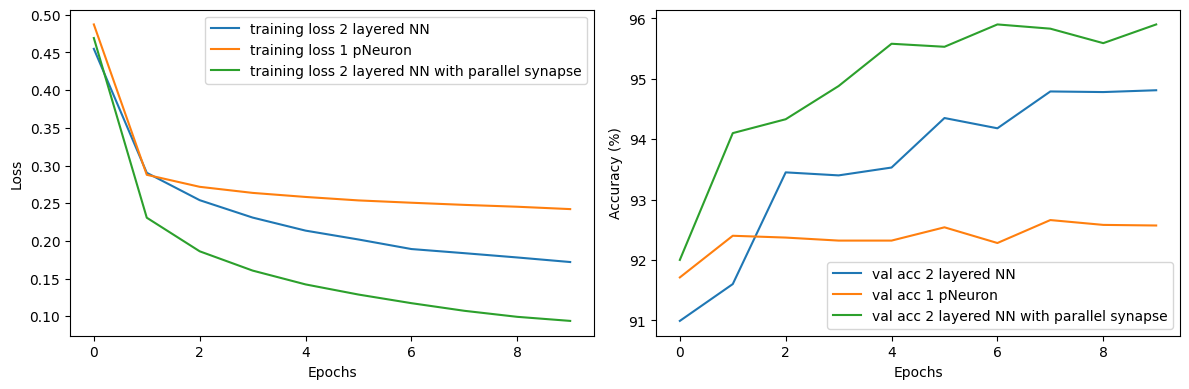

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# Training loop
num_epochs = 10

for model_i, model in enumerate(models):
    # Initialize model, criterion, and optimizer 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.view(-1, 28*28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses[model_names[model_i]].append(running_loss / len(trainloader))

        # Validation loop for accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total 
        
        
        accuracies[model_names[model_i]].append(accuracy)
        
        print(model_names[model_i] + f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")


# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for m in model_names:
    plt.plot(losses[m], label="training loss "+ m)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for m in model_names:
    plt.plot(accuracies[m], label="val acc "+ m)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()


Define a pNeuron, run MNIST task

In [4]:
outputs.shape, labels.shape

(torch.Size([16, 10]), torch.Size([16]))